# Preliminaries

In [1]:
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import copy

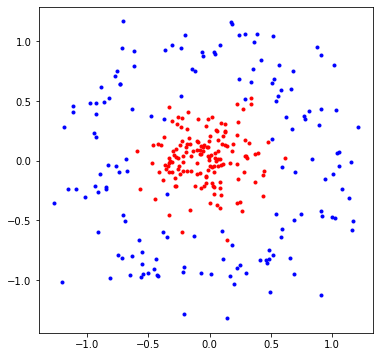

In [2]:
X,y = make_circles(n_samples = 300, noise=0.2, factor=0.1)
n,d = X.shape
plt.figure(1,figsize=[6,6])
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.r')
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.b')

In [3]:
def sgm(x):
    res = 1 / (1 + np.exp(-x))
    return res

def onehot(y,i):
    return 1-np.array(list(bin(y[i]+1)[2:].zfill(2))).astype(int)

In [4]:
print(onehot(y, 200))

[0 1]


# Exercise 1 : Network creation

In [5]:
class InputUnit:
    def __init__(self,data):
        self.data = data        # one column of matrix X
        self.n = data.shape[0]  # dataset size
        self.k = 0              # layer number
        self.z = 0              # unit output
        
    def plug(self,aUnit):
        aUnit.preceding.append(self)
        aUnit.npr += 1
        
    def forward(self,i):
        self.z = self.data[i]
        return self.z

In [6]:
in1 = InputUnit(X[:0])
in2 = InputUnit(X[:1])

In [7]:
class NeuralUnit:
    
    def __init__(self,k,u):
        self.u = u          # unit number
        self.preceding = [] # list of preceding neurons
        self.npr = 0        # length of list preceding
        self.following = [] # list of following neurons
        self.nfo = 0        # length of list following
        self.k = k          # layer number
        self.w = 0          # unit weight
        self.b = 0          # unit intercept
        self.z = 0          # unit output
        
    def reset_params(self):
        self.w = np.random.randn(self.npr)
        self.b = np.random.randn()
    
        
    def plug(self,aUnit):
        self.following.append(aUnit)
        self.nfo += 1
        aUnit.preceding.append(self)
        aUnit.npr += 1
        
    def forward(self,i):
        z = 0
        for k,prevNU in enumerate(self.preceding):
            z += self.w[k]*prevNU.forward(i)
        z += self.b
        z = sgm(z)
        self.z = z
        return z
        
    def backprop(self,i,delta):
        self.delta = np.zeros(self.w.shape)
        self.w_grad = np.zeros(self.w.shape)
        self.b_grad = 0
        for v in range(len(self.preceding)):
            self.delta[v] = delta[self.u]*self.z*(1-self.z)*self.w[v]
            self.w_grad[v] = self.z*(1-self.z)*self.preceding[v].z*delta[self.u]
        self.b_grad = self.z*(1-self.z)*delta[self.u]

In [8]:
neurone1_1 = NeuralUnit(0,0)
neurone1_2 = NeuralUnit(0,1)
neurone2_1 = NeuralUnit(1,0)

In [9]:
class Loss:
    
    def __init__(self,y,k):
        self.preceding = [] # list of preceding neurons
        self.npr = 0        # length of list preceding
        self.y = y          # array of class labels of the training data
        self.k = k          # layer index
        
        
    def forward(self,i):
        zin = self.preceding[0].forward(i)
        if self.y[i] == 0:
            return -np.log(1-zin)
        else:
            return -np.log(zin)
        
    def backprop(self,i):
        self.delta = np.zeros((1,))
        zin = self.preceding[0].z
        if self.y[i] == 0:
            dli = 1/(1-zin)
        else:
            dli = -1/zin
        self.delta[0] = dli
        return dli

In [10]:
loss = Loss(y,2)

In [11]:
class MLP:
    
    def __init__(self,X,y,archi):
        self.archi = archi
        self.X = X
        self.n = X.shape[0]
        self.y = y
        self.K = len(archi)     # number of layers (including input layer)
        
        # creating network
        net = []
        for i in range(len(archi)):
            layer=[]
            for j in range(archi[i]):
                if i==0:
                    Nu = InputUnit(X[:,j])
                else :
                    Nu = NeuralUnit(i,j)
                layer.append(Nu)  
            net.append(layer) 
        net.append([Loss(y,len(archi))])
        self.net = net
        
        # plug network
        for l in range(len(net)-1):
            for n in range(len(net[l])):
                for next_neuron in net[l+1]:
                    net[l][n].plug(next_neuron)   
                    if l!=0 and l != len(net)-1:
                        net[l][n].reset_params()

    def forward(self,i):
        return self.net[-1][-1].forward(i)
    
    def backprop(self,i):
        for k in range(self.K,0,-1):
            if k == self.K:
                self.net[k][0].backprop(i)
                deltas = self.net[k][0].delta
            else:
                deltas_new = np.zeros((self.net[k][0].npr,))
                for u in range(len(self.net[k])):
                    self.net[k][u].backprop(i,deltas)
                    deltas_new += self.net[k][u].delta
                deltas = deltas_new
                
                
    def update(self,eta):
        for l in range(1,len(self.net)-1):
            for u in self.net[l]:
                u.w -= eta*u.w_grad
                u.b -= eta*u.b_grad
                
    def train(self,epochs,eta):
        for epoch in range(epochs):
            print("epoch ",epoch+1,"/",epochs,'...')
            for i in range(self.n):
                self.forward(i)
                self.backprop(i)
                self.update(eta)
                
    def predict(self,i):
        return self.net[-2][0].forward(i)

In [12]:
mlp = MLP(X,y,[2,2,1]).net
mlp

[[<__main__.InputUnit at 0x280d9dab760>,

In [13]:
mlp = MLP(X,y,[2,2,1])

In [14]:
mlp.forward(1)

1.8204760075600814

# Exercise 2 : Forward pass

# Exercise 3 : Backprop

In [15]:
i = 0
archi = [d,10,1]
mlp = MLP(X,y,archi)
mlp.forward(i)
mlp.backprop(i)
epsi=1e-5
mlp2 = copy.deepcopy(mlp)
mlp2.net[1][0].w[0] = mlp.net[1][0].w[0]+epsi
print("numerical derivative is : ",(mlp2.forward(i) - mlp.forward(i))/epsi)
print("computed derivative is : ",mlp.net[1][0].w_grad[0])

numerical derivative is :  -0.03511483859242048
computed derivative is :  -0.03511485448538809


# Exercise 4 : SGD training of the network

In [16]:
mlp.train(50,0.01)

epoch  1 / 50 ...
epoch  2 / 50 ...
epoch  3 / 50 ...
epoch  4 / 50 ...
epoch  5 / 50 ...
epoch  6 / 50 ...
epoch  7 / 50 ...
epoch  8 / 50 ...
epoch  9 / 50 ...
epoch  10 / 50 ...
epoch  11 / 50 ...
epoch  12 / 50 ...
epoch  13 / 50 ...
epoch  14 / 50 ...
epoch  15 / 50 ...
epoch  16 / 50 ...
epoch  17 / 50 ...
epoch  18 / 50 ...
epoch  19 / 50 ...
epoch  20 / 50 ...
epoch  21 / 50 ...
epoch  22 / 50 ...
epoch  23 / 50 ...
epoch  24 / 50 ...
epoch  25 / 50 ...
epoch  26 / 50 ...
epoch  27 / 50 ...
epoch  28 / 50 ...
epoch  29 / 50 ...
epoch  30 / 50 ...
epoch  31 / 50 ...
epoch  32 / 50 ...
epoch  33 / 50 ...
epoch  34 / 50 ...
epoch  35 / 50 ...
epoch  36 / 50 ...
epoch  37 / 50 ...
epoch  38 / 50 ...
epoch  39 / 50 ...
epoch  40 / 50 ...
epoch  41 / 50 ...
epoch  42 / 50 ...
epoch  43 / 50 ...
epoch  44 / 50 ...
epoch  45 / 50 ...
epoch  46 / 50 ...
epoch  47 / 50 ...
epoch  48 / 50 ...
epoch  49 / 50 ...
epoch  50 / 50 ...


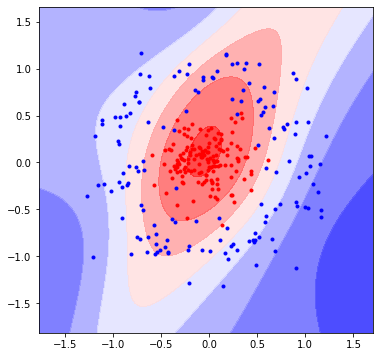

In [17]:
h = 0.02
x1_min, x1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
x2_min, x2_max = X[:, 1].min() - .5, X[:, 1].max() + .5
x11, x22 = np.meshgrid(np.arange(x1_min, x1_max, h),np.arange(x2_min, x2_max, h))
X_disp = np.c_[x11.ravel(), x22.ravel()]
n_disp = X_disp.shape[0]
Z=[]
for u in range(mlp.archi[0]):
    mlp.net[0][u].data = X_disp[:,u]
for i in range(n_disp):
    Z.append(mlp.predict(i))
for u in range(mlp.archi[0]):
    mlp.net[0][u].data = X[:,u]
Z=np.array(Z)
Z = Z.reshape(x11.shape)
plt.figure(2,figsize=[6,6])
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.r')
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.b')
plt.contourf(x11,x22,Z,cmap=plt.cm.bwr,alpha=.8)
plt.show()